In [1]:
# Import Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from string import punctuation

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import text, sequence
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
# import libraries
train_data = pd.read_csv('./Corona_NLP_train.csv', encoding='latin_1')
test_data = pd.read_csv("./Corona_NLP_test.csv",encoding='latin_1')

# display first 5 instance per set
display(train_data.head())
display(test_data.head())

train_data.info()
test_data.info()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+

In [3]:
train_data[3:4]['OriginalTweet'].values

array(["My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"],
      dtype=object)

In [4]:
# checking for null values
display(train_data.isnull().sum())
display(test_data.isnull().sum())

## missing found only in location, no particular need to drop these values

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [5]:
# dropping duplicates
train_data.drop_duplicates(inplace= True)
test_data.drop_duplicates(inplace=True)

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 207.7+

In [6]:
# copy the dataset into new data
##
train_df = train_data.copy().loc[:, ["OriginalTweet", "Sentiment"]]
test_df = test_data.copy().loc[:, ["OriginalTweet", "Sentiment"]]

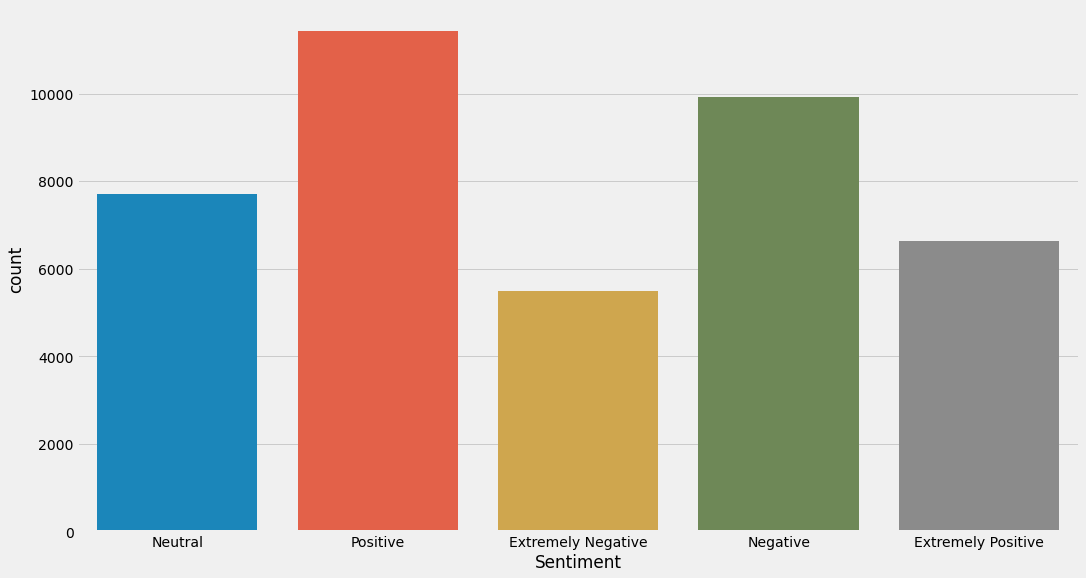

In [7]:
# viewing class distribution of training dataset
sns.countplot(data=train_df, x='Sentiment')
plt.show()

In [8]:
# convert extremely positive -> positive
# extremely negative -> negative
# doesn't really change polarity since it is hard to infer what is "extremely"
def map_sentiment(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'neutral'
    
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda y: map_sentiment(y))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda y: map_sentiment(y))

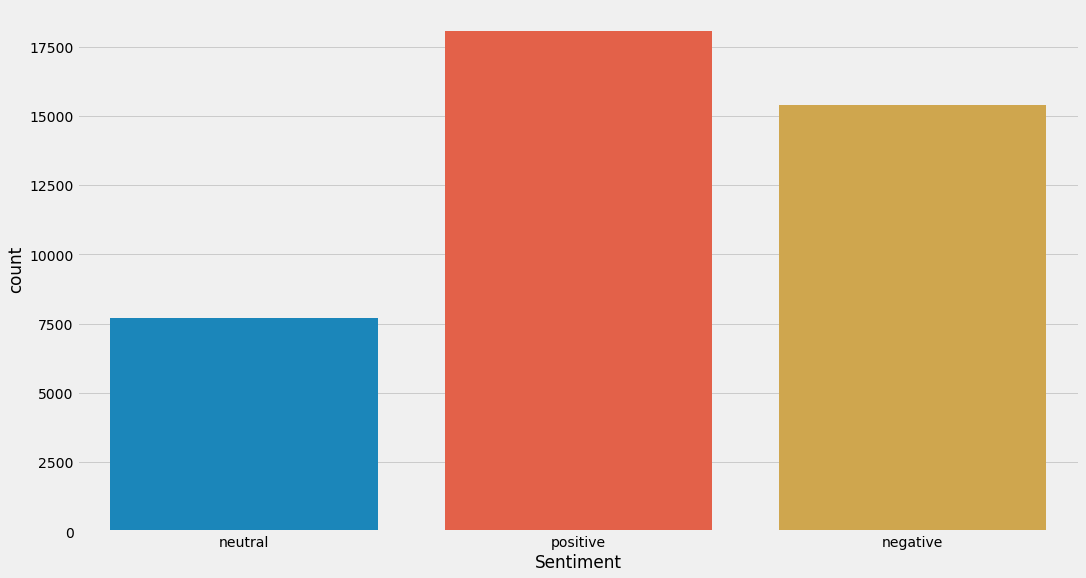

In [9]:
# show class distribution after mapping values
sns.countplot(data=train_df, x='Sentiment')
plt.show()

In [10]:
%%time
def text_processing(text):

    # load stop words
    stop_word = stopwords.words('english')
    
    # prepare lemmatizer
    lemma = nltk.WordNetLemmatizer()

    # remove urls
    text = re.sub(r'http\S+', " ", text)

    # remove mentions
    text = re.sub(r'@\w+',' ',text)

    # remove hastags
    text = re.sub(r'#\w+', ' ', text)

    # remove digits
    text = re.sub(r'\d+', ' ', text)

    # remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    # Removal of Special Characters
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # removal of punctuation marks
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove stop words and lemmatization
    text = text.split()
    text = " ".join([lemma.lemmatize(word.lower()) for word in text if not word in stop_word])
    
    
    return text

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: text_processing(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: text_processing(x))

train_df.head()

Wall time: 17.3 s


,OriginalTweet,Sentiment
0,,neutral
1,advice talk neighbour family exchange phone nu...,positive
2,coronavirus australia woolworth give elderly d...,positive
3,my food stock one empty please panic there wil...,positive
4,me ready go supermarket outbreak not i paranoi...,negative


In [11]:
text = "My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"
text_processing(text)

'my food stock one empty please panic there will be enough food for everyone take need stay calm stay safe'

In [12]:
# mapping sentiments with ordinal values
l = {'negative': 0, 'neutral': 1, "positive": 2}

train_df['Sentiment'] = train_df['Sentiment'].map(l)
test_df['Sentiment']  = test_df['Sentiment'].map(l)

train_df.head(10)

,OriginalTweet,Sentiment
0,,1
1,advice talk neighbour family exchange phone nu...,2
2,coronavirus australia woolworth give elderly d...,2
3,my food stock one empty please panic there wil...,2
4,me ready go supermarket outbreak not i paranoi...,0
5,a news region first confirmed covid case came ...,2
6,cashier grocery store sharing insight to prove...,2
7,wa supermarket today didn buy toilet paper,1
8,due covid retail store classroom atlanta open ...,2
9,for corona prevention stop buy thing cash use ...,0


In [13]:
x_train = train_df['OriginalTweet'].copy()
x_test = test_df['OriginalTweet'].copy()

y_train = train_df['Sentiment'].copy()
y_test = test_df['Sentiment'].copy()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((41157,), (41157,), (3798,), (3798,))

In [14]:
# finding the string with the most words
max_len = np.max(x_train.apply(lambda x :len(x)))
print(max_len)

281


In [15]:
def convert_dtypes(x, y):
    return tf.cast(x, tf.uint16), tf.cast(y, tf.uint8)

## TOKENIZATION
tokenizer = Tokenizer()

tokenizer.fit_on_texts(x_train)
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

x_train, y_train = convert_dtypes(x_train, y_train)
x_test, y_test = convert_dtypes(x_test, y_test)

print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 28841
Max sequence length: 281


In [16]:
sample = tokenizer.texts_to_sequences(['my food stock one empty please panic there will be enough food for everyone take need stay calm stay safe'])
sample = pad_sequences(sample, maxlen=max_len, padding='post')
sample[0]

array([112,   6,  31,  32, 153,  44,  22, 141, 397, 366, 180,   6, 167,
        80,  70,  14,  55, 885,  55, 103,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [17]:
tf.keras.layers.Embedding(vocab_length, 16, input_length=max_len)(sample)

<tf.Tensor: shape=(1, 281, 16), dtype=float32, numpy=
array([[[-0.047013  , -0.03013277, -0.04458842, ...,  0.03149048,
          0.0259943 , -0.02615925],
        [-0.00704461, -0.041265  , -0.04536719, ..., -0.01588186,
          0.02548971, -0.03393946],
        [ 0.00041825,  0.0322791 ,  0.02646789, ...,  0.01117826,
         -0.03286733, -0.01373988],
        ...,
        [ 0.00347955, -0.02554839,  0.03587326, ..., -0.03681952,
         -0.0348217 , -0.02016741],
        [ 0.00347955, -0.02554839,  0.03587326, ..., -0.03681952,
         -0.0348217 , -0.02016741],
        [ 0.00347955, -0.02554839,  0.03587326, ..., -0.03681952,
         -0.0348217 , -0.02016741]]], dtype=float32)>

In [18]:
from tensorflow.keras.layers import *

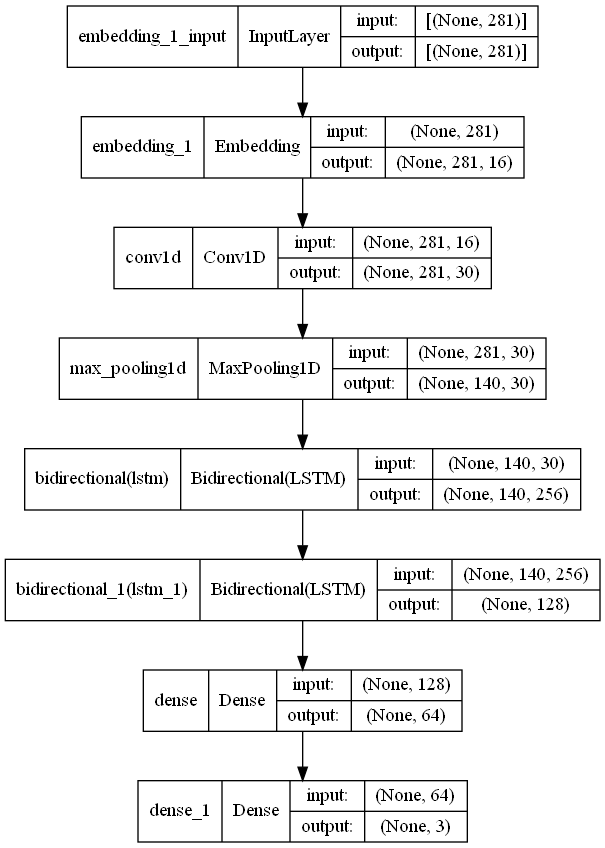

In [19]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    
    # Implementing CNN Layer
    Conv1D(filters=30, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, strides=2),

    Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True,
               recurrent_dropout=0, dropout=0.25, recurrent_activation='sigmoid')),

    Bidirectional(LSTM(units=64, recurrent_dropout=0, dropout=0, activation='tanh',
               recurrent_activation='sigmoid', unroll=False, use_bias=True)),
    
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

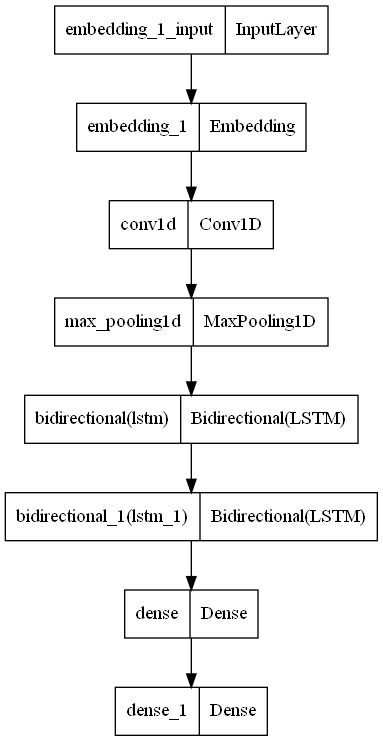

In [20]:
tf.keras.utils.plot_model(model, show_shapes=False)

In [21]:
%%time
num_epochs = 20
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE

history = model.fit(
    x = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(AUTO),
    validation_data=tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTO),
    epochs=num_epochs,
    use_multiprocessing=True,
    workers=4
)


Epoch 1/20
161/161 [==============================] - 80s 325ms/step - loss: 0.8922 - accuracy: 0.5350 - val_loss: 0.7159 - val_accuracy: 0.7059
Epoch 2/20
161/161 [==============================] - 78s 489ms/step - loss: 0.4543 - accuracy: 0.8318 - val_loss: 0.4859 - val_accuracy: 0.8357
Epoch 3/20
161/161 [==============================] - 79s 489ms/step - loss: 0.2870 - accuracy: 0.9063 - val_loss: 0.4786 - val_accuracy: 0.8399
Epoch 4/20
161/161 [==============================] - 73s 455ms/step - loss: 0.2216 - accuracy: 0.9298 - val_loss: 0.5387 - val_accuracy: 0.8357
Epoch 5/20
161/161 [==============================] - 79s 492ms/step - loss: 0.1917 - accuracy: 0.9398 - val_loss: 0.5775 - val_accuracy: 0.8381
Epoch 6/20
161/161 [==============================] - 81s 501ms/step - loss: 0.1667 - accuracy: 0.9479 - val_loss: 0.6516 - val_accuracy: 0.8231
Epoch 7/20
161/161 [==============================] - 89s 555ms/step - loss: 0.1540 - accuracy: 0.9521 - val_loss: 0.5823 - val_ac

Accuracy on training data is:- 97.88857102394104 %
Loss 6.329451501369476
Accuracy on validation data is:- 78.90995144844055 %
Loss 98.75178337097168


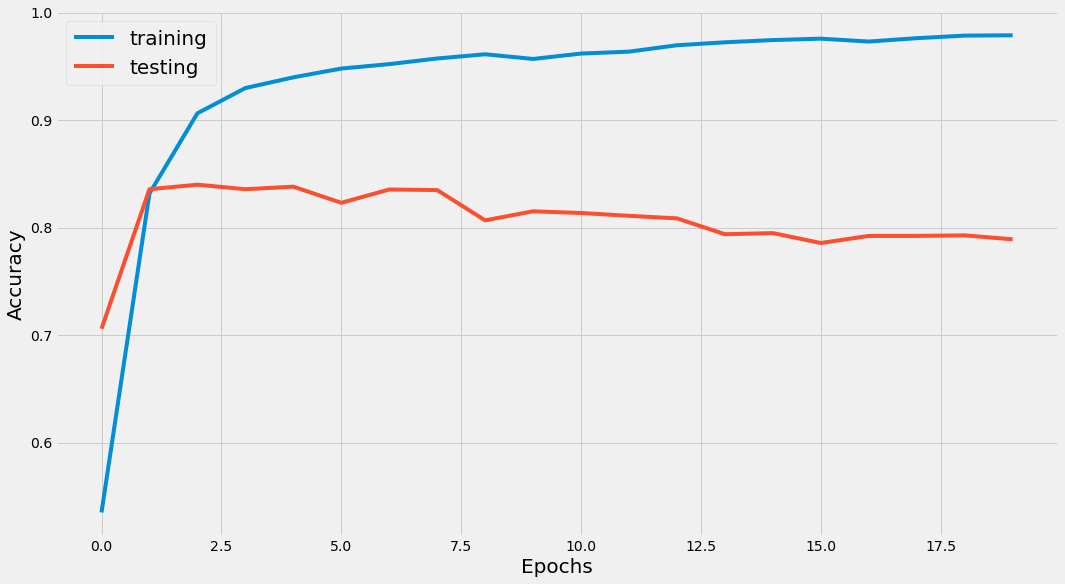

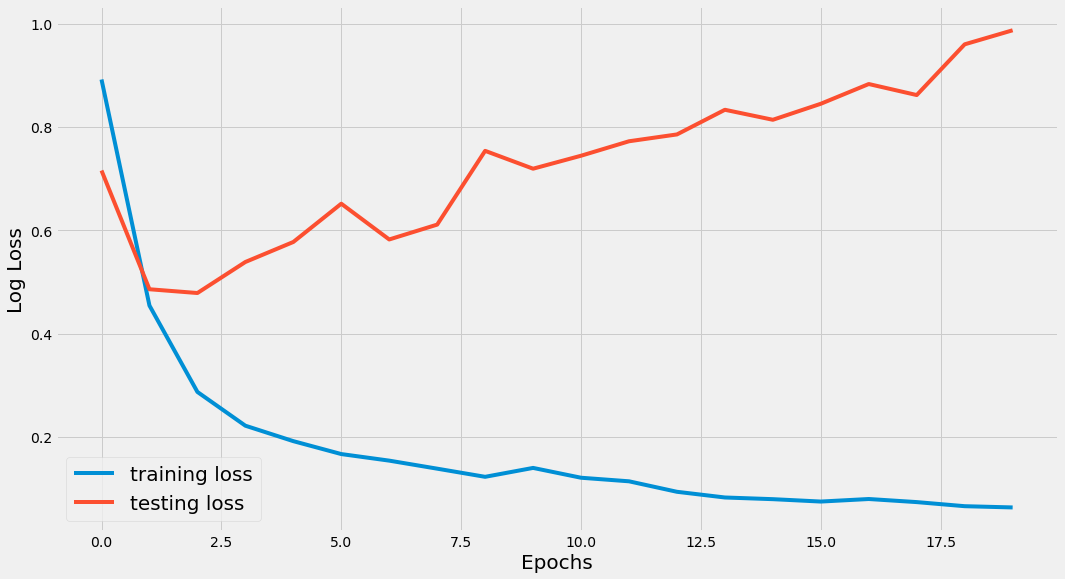

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

plt.plot(acc, label='training')
plt.plot(val_acc, label='testing')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='testing loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Log Loss', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [23]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

119/119 [==============================] - 4s 32ms/step - loss: 0.9875 - accuracy: 0.7891


[0.987517774105072, 0.7890995144844055]

In [24]:
# produce a 1D matrix of probabilities
pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)

<AxesSubplot:>

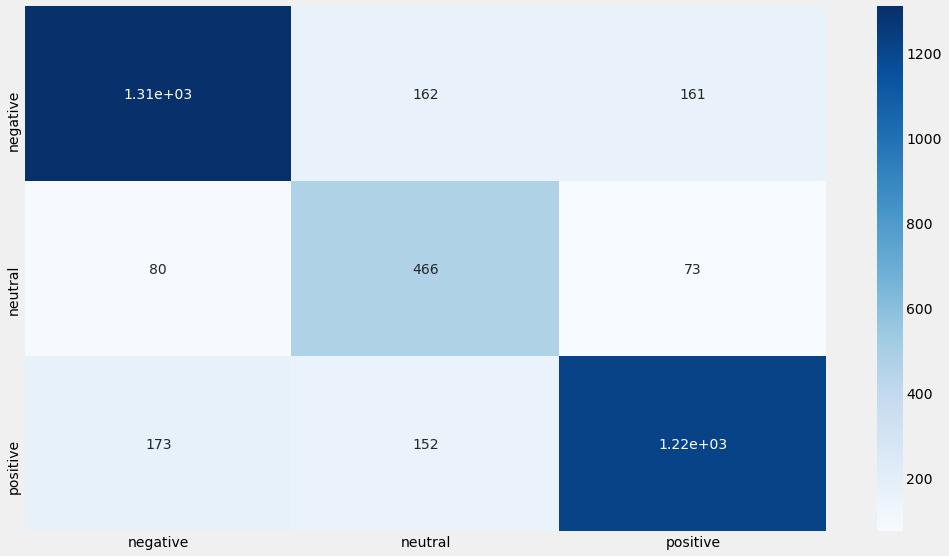

In [25]:
cm = confusion_matrix(y_test, pred_classes)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3g', xticklabels=l.keys(), yticklabels=l.keys())

In [26]:
print(classification_report(y_test, pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1633
           1       0.60      0.75      0.67       619
           2       0.84      0.79      0.81      1546

    accuracy                           0.79      3798
   macro avg       0.76      0.78      0.77      3798
weighted avg       0.80      0.79      0.79      3798



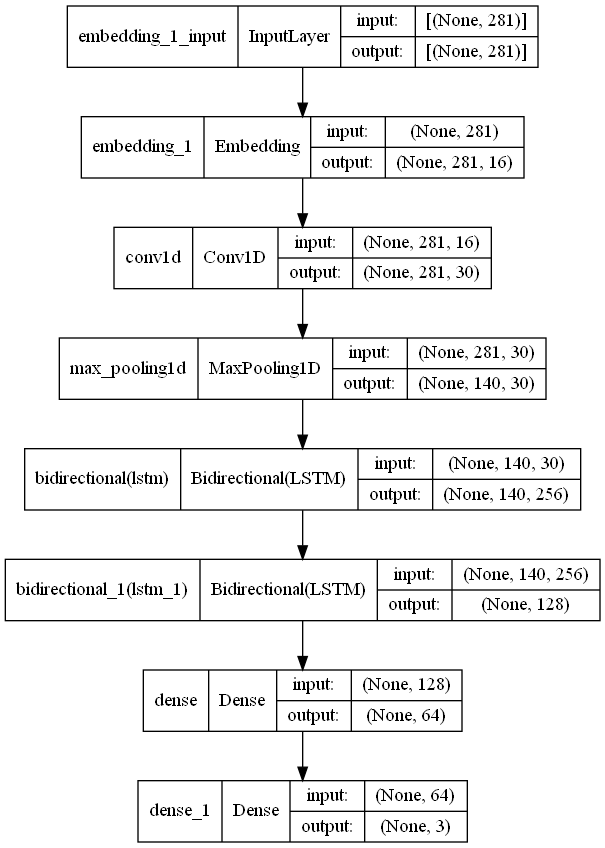

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)